In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle
file = open('dataset/dataset.pkl','rb')
DATA = pickle.load(file)
pheno = DATA['pheno']
X_gpa = DATA['X_gpa']
X_snps = DATA['X_snps']
X_genexp = DATA['X_genexp']
antibiotics = pheno.columns[1:]

Figure 4

In [2]:
import os
import ast

def process_results_csv(directory):
    # Initialiser les dictionnaires pour stocker les recalls et les comptes de colonnes
    recall_data = {}
    column_counts = {}

    # Parcourir les fichiers dans le répertoire dans l'ordre alphabétique
    for file_name in sorted(os.listdir(directory)):
        if file_name.startswith("result_") and file_name.endswith(".csv"):
            model_name = file_name[len("result_"):-4]  # Extraire le nom du modèle à partir du nom du fichier
            file_path = os.path.join(directory, file_name)

            # Lire le fichier CSV
            df = pd.read_csv(file_path, sep=';')

            for _, row in df.iterrows():
                antibiotic = row['Antibiotique']
                recall = row['Recall']
                gpa_columns = ast.literal_eval(row['Colonnes_GPA'])
                snps_columns = ast.literal_eval(row['Colonnes_SNPs'])
                genexp_columns = ast.literal_eval(row['Colonnes_Expression_Genetique'])

                # Mettre à jour les données de recall
                if antibiotic not in recall_data:
                    recall_data[antibiotic] = {}
                recall_data[antibiotic][model_name] = recall

                # Mettre à jour les données de comptes de colonnes
                if antibiotic not in column_counts:
                    column_counts[antibiotic] = {}
                column_counts[antibiotic][model_name] = {
                    'GPA': len(gpa_columns),
                    'SNPs': len(snps_columns),
                    'GenExp': len(genexp_columns)
                }

    # Créer des DataFrames à partir des dictionnaires
    recall_df = pd.DataFrame(recall_data).T
    column_counts_df = {}
    for col_type in ['GPA', 'SNPs', 'GenExp']:
        column_counts_df[col_type] = pd.DataFrame(
            {antibiotic: {model: data[col_type] for model, data in models.items()}
             for antibiotic, models in column_counts.items()}
        ).T

    return recall_df, column_counts_df

recall_df, column_counts_df = process_results_csv('result')

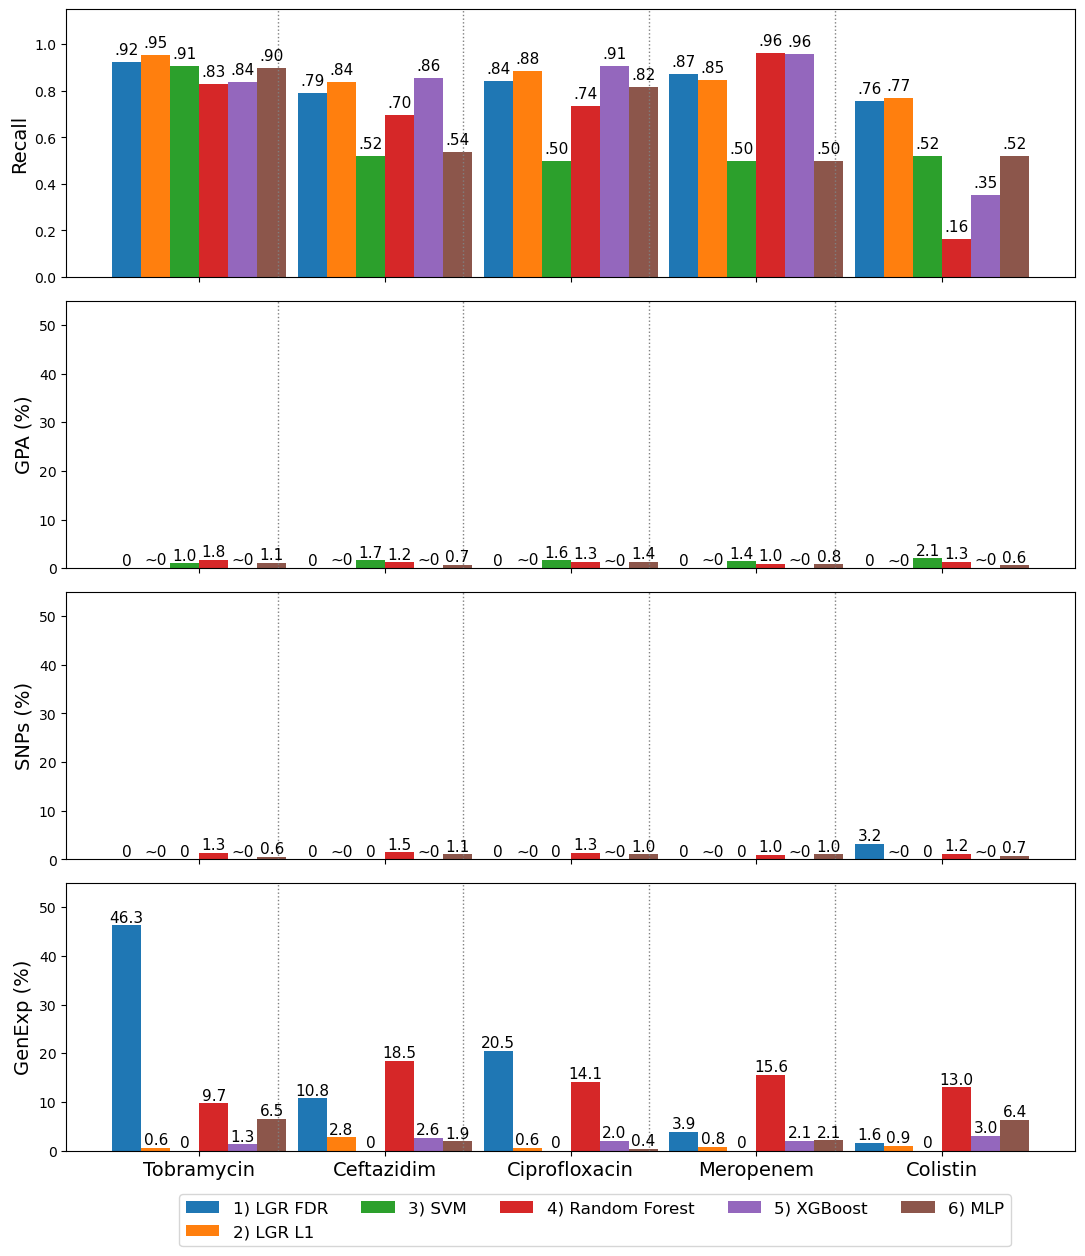

In [3]:
def plot_multiple_bar_charts_with_small_spacing(recall_df, column_counts_df):
    models = recall_df.columns
    num_antibiotics = len(antibiotics)
    small_spacing = 0.4  # Espacement infime entre blocs
    x = np.arange(num_antibiotics) * (len(models) * 0.2 + small_spacing)  # Positions des groupes avec petite séparation
    width = 0.25  # Largeur des barres

    # Préparer les datasets et normaliser en pourcentage
    gpa_data = column_counts_df['GPA'] / X_gpa.shape[1] * 100
    snps_data = column_counts_df['SNPs'] / X_snps.shape[1] * 100
    genexp_data = column_counts_df['GenExp'] / X_genexp.shape[1] * 100

    max_value = 50  # À ajuster si nécessaire

    datasets = [
        ('Recall', recall_df),
        ('GPA', gpa_data),
        ('SNPs', snps_data),
        ('GenExp', genexp_data)
    ]

    # Créer les sous-graphiques
    fig, axes = plt.subplots(nrows=len(datasets), ncols=1, figsize=(12, 12), sharex=True)

    # Augmentation des tailles de police
    title_fontsize = 14
    label_fontsize = 14
    tick_fontsize = 14

    for ax, (title, data) in zip(axes, datasets):
        for i, model in enumerate(models):
            bars = ax.bar(x + i * width, data[model], width, label=model)

            # Ajouter les chiffres sur les barres
            for bar in bars:
                height = bar.get_height()
                if title == 'Recall':
                    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.2f}'.lstrip('0'), 
                            ha='center', va='bottom', color='black', fontsize=11)
                else:
                    if height == 0:
                        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, '0', 
                                ha='center', va='bottom', color='black', fontsize=11)
                    elif height < 0.1 and height > 0:
                        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, '~0', 
                                ha='center', va='bottom', color='black', fontsize=11)
                    else:
                        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.1f}', 
                                ha='center', va='bottom', color='black', fontsize=11)

        # Configurer l'axe
        ax.set_ylabel(title + (' (%)' if title != 'Recall' else ''), fontsize=label_fontsize)
        if title != 'Recall':
            ax.set_ylim(0, max_value * 1.1)  # Appliquer la même échelle pour GPA, SNPs et GenExp
        if title == 'Recall':
            ax.set_ylim(0, 1.15)

        # Ajouter les ticks et labels avec espacement
        ax.set_xticks(x + width * (len(models) - 1) / 2)
        ax.set_xticklabels(antibiotics, rotation=0, ha='center', fontsize=tick_fontsize)
        
        # Ajouter des traits pointillés pour séparer les blocs d'antibiotiques
        for pos in range(len(antibiotics) - 1):  # Boucle sur les paires adjacentes
            midpoint = (x[pos] + x[pos + 1]) / 2 + 0.5  # Calculer la position médiane A MODIFIER
            ax.axvline(x=midpoint, color='gray', linestyle='dotted', linewidth=1)
  
    # Ajouter la légende sous tous les graphiques
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=12)
    
    # Ajuster les marges pour inclure la légende
    plt.tight_layout()
    plt.subplots_adjust(right=0.90)  # Réserver de l'espace pour la légende
    plt.show()

# Tracer les graphiques
plot_multiple_bar_charts_with_small_spacing(recall_df, column_counts_df)